# Image Classification -- Understanding the Process
<div class="alert alert-block alert-info">
<b>Content:</b> We want to understand, how a neural network perceives images.

* For understanding the feature extraction:
    * we use a pretrained network (Resnet50),
    * we classify an image, and
    * we look at different stages of the image travelling through the net.
* For an explanation:
    * we use LIME to train an explanatory model
    * we visualize the regions of the image that were most important.
</div>

<div class="alert alert-block alert-warning">
<b>Install:</b> use python image processin (opencv) - for that purpose install opencv-python
</div>

Code taken and adapted from https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/ and 

In [643]:
import torch
import torch.nn as nn
from torchvision import models # PyTorch image processing lib
from tqdm.notebook import trange, tqdm

## Load a pretrained Network (ResNet50)
* download the pretrained network (model weights)
* print the network

In [644]:
model = models.resnet50(pretrained=True)
print(model)

c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jojom\miniconda3\envs\condaAP\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [645]:
num_params=sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Number of learnable paramters: "+"{:,}".format(num_params));

Number of learnable paramters: 25,557,032


## Find Convolutional Layers

In [646]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
model_children = list(model.children()) 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {len(conv_layers)}")

Total convolutional layers: 49


## Load and Preprocess an image

In [647]:
import cv2 as cv # python library for image processing
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

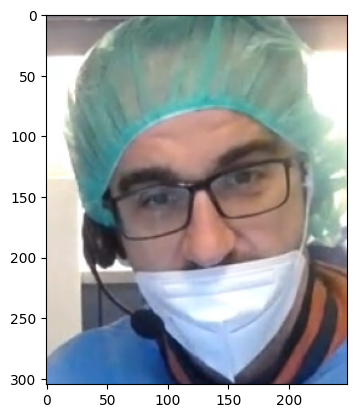

In [676]:
raw = cv.imread("data/images/mann_explained.png") # f"data/images/space_shuttle.jpg")# 
raw = cv.cvtColor(raw, cv.COLOR_BGR2RGB) # convert colorspace
plt.imshow(raw)
plt.show()

## umformen

In [677]:
pil_transform = transforms.Compose([
    transforms.ToPILImage(), # Python Imaging Library
    transforms.Resize(224),
    transforms.CenterCrop(224),
    ])    

# adapt normalization from https://pytorch.org/vision/master/models.html
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     

preprocess_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize_transform
    ])    

#added
test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


Original image shape:  (305, 248, 3)


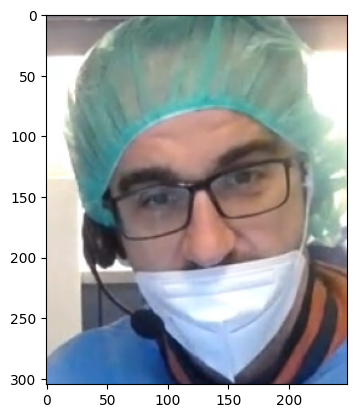

In [678]:
print("Original image shape: ", raw.shape)
plt.imshow(raw)

PIL image is in mode:  RGB with  3 channels and size: (224, 224)


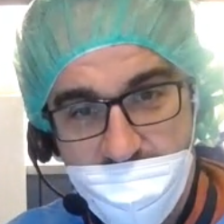

In [679]:
np_img = np.array(raw)
pil_img = pil_transform(np_img)

print("PIL image is in mode: ", pil_img.mode, "with ", len(pil_img.split()), "channels and size:", pil_img.size)
display(pil_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


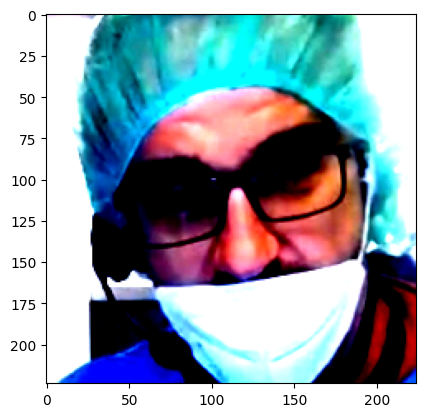

In [680]:
tensor_img = preprocess_transform(pil_img)
print(tensor_img.size())
# unsqueeze to add a batch dimension
#img = img.unsqueeze(0)
print(tensor_img.size())
plt.imshow(tensor_img.transpose(2,0).transpose(0,1))

## Predict the image

In [681]:
# added:
from model import model_static
model = model_static("data/model_weights.pkl")
model_dict = model.state_dict()
snapshot = torch.load("data/model_weights.pkl")
model_dict.update(snapshot)
model.load_state_dict(model_dict)

model.cuda()
#model.to(torch.device('cuda:1'))
model.train(False);

loading saved model weights


In [682]:
test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [683]:
out=model(tensor_img.unsqueeze_(0).cuda())

# added
score = torch.sigmoid(out)
print(score)

tensor([[0.9878]], device='cuda:0', grad_fn=<SigmoidBackward0>)


We get 1000 raw scores. One per class.

In [684]:
_, index = torch.max(out, 1)
index

tensor([0], device='cuda:0')

## Find an Explanation for the Classification

For the Lime package install ````lime````

In [685]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [686]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    out = model(batch.cuda())
    return torch.sigmoid(out).cpu().detach().numpy()

In [687]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(np_img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [00:17<00:00, 56.41it/s]


<class 'numpy.ndarray'>
(224, 224, 3)


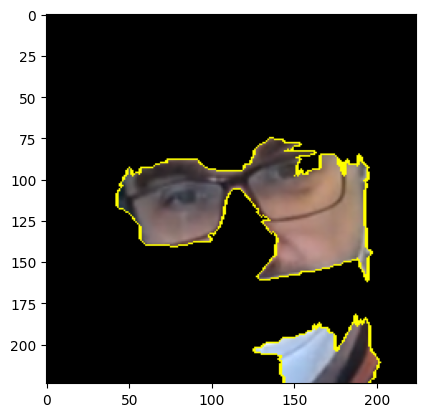

In [688]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
print(type(img_boundry1))
print(img_boundry1.shape)
plt.imshow(img_boundry1);
plt.savefig("data/images/mann_explained.jpg")

<div class="alert alert-block alert-success">
<b>Take Aways:</b> 

* We can analyze and visualize the decision process in a deep learning architecture (to some degree).
* The feature engineering transforms the image with focus on different aspects -- feature maps in the same layer learn different things.
* In the early layers, we can sometimes still interpret certain aspects of the image or the focus features.
* The results of later layers are non-readable for humans.
* For each instance that we want to explain, one new model is trained!
</div>

<div class="alert alert-block alert-warning">
<b>WARNING:</b> 

* When using pre-trained networks, always check the required preprocessing of the data!
</div>
